In [1]:
import os
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path

import matplotlib.pyplot as plt
import torch

from lhotse import CutSet, Fbank, LilcomFilesWriter, WavAugmenter
from lhotse.dataset import SpeechRecognitionDataset
from lhotse.recipes.librispeech import download_and_untar, prepare_librispeech

# Settings for paths

In [2]:
root_dir = Path('data')
corpus_dir = root_dir / 'LibriSpeech'
output_dir = root_dir / 'mini_librispeech_nb'

# Download and untar

In [3]:
download_and_untar(root_dir)

# Prepare audio and supervision manifests

In [4]:
mini_librispeech_manifests = prepare_librispeech(corpus_dir, output_dir=output_dir)

# [Optional] Data augmentation

In [5]:
use_data_augmentation = False
augmenter = WavAugmenter.create_predefined('pitch_reverb_tdrop', sampling_rate=16000) if use_data_augmentation else None
# It seems when spawning multiple Python subprocesses with the same sox handle it raises "std::runtime_error: Couldn't close file"
# The issue seems to happen only in a Jupyter notebook on Mac OS X, hence the work around below.
num_jobs = 1 if use_data_augmentation else os.cpu_count()

# Extract features

In [6]:
for partition, manifests in mini_librispeech_manifests.items():
    with LilcomFilesWriter(f'{output_dir}/feats_{partition}') as storage, ProcessPoolExecutor(num_jobs) as ex:
        cut_set = CutSet.from_manifests(
            recordings=manifests['recordings'],
            supervisions=manifests['supervisions']
        ).compute_and_store_features(
            extractor=Fbank(),
            storage=storage,
            augmenter=augmenter,
            executor=ex
        ).pad()
    mini_librispeech_manifests[partition]['cuts'] = cut_set
    cut_set.to_json(output_dir / f'cuts_{partition}.json.gz')

# Make PyTorch Dataset

In [7]:
cuts_dev = SpeechRecognitionDataset(mini_librispeech_manifests['dev-clean-2']['cuts'])
cuts_train = SpeechRecognitionDataset(mini_librispeech_manifests['train-clean-5']['cuts'])

# Illustration of an example

Transcript: IF THE READER WILL EXCUSE ME I WILL SAY NOTHING OF MY ANTECEDENTS NOR OF THE CIRCUMSTANCES WHICH LED ME TO LEAVE MY NATIVE COUNTRY THE NARRATIVE WOULD BE TEDIOUS TO HIM AND PAINFUL TO MYSELF
Supervisions mask: tensor([1., 1., 1.,  ..., 0., 0., 0.], dtype=torch.float64)
Feature matrix:


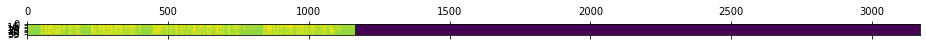

In [8]:
sample = cuts_dev[0]
print('Transcript:', sample['text'])
print('Supervisions mask:', sample['supervisions_mask'])
print('Feature matrix:')
plt.matshow(sample['features'].transpose(0, 1).flip(0));

# Make PyTorch Dataloader

In [9]:
train_dl = torch.utils.data.DataLoader(cuts_train, batch_size=16, shuffle=True)
dev_dl = torch.utils.data.DataLoader(cuts_dev, batch_size=32)

In [10]:
for batch in train_dl:
    for key, value in batch.items():
        print(key, '- shape or length:', end=' ')
        if isinstance(value, torch.Tensor):
            print(value.shape)
        else:
            print(len(value))
    break

features - shape or length: torch.Size([16, 1727, 40])
text - shape or length: 16
supervisions_mask - shape or length: torch.Size([16, 1727])
